Sparse Modeling for Inelastic Neutron Scattering
=======================================================

SpM-INS is a tool for analyzing inelastic neutron scattering (INS) specturm. The purpose of this software is to estimate the true spectrum from experimental INS data. The detail algorithm is presented in the below article.

* K.Yonaga, S.Hayashida, M.Ohzeki, and T.Masuda, "Sparse Modeling for Inealstic Neutron Scattering," to be appeard.

In this notebook, we demonstrate an example of spectrum estimation and hyperparameter tuning with using artificially synthetic data.


In [1]:
%load_ext autoreload
%autoreload 2

from parameters import *
from spectrum import Spectrum
from linear_measurement import *
from total_square_variation import *
from empirical_parameter import *
from admm import ADMMSolver
from cross_validation import CrossValidationManager

## Define system model

Let us consider a $(\bm{Q}, E)$-space, where $\bm{Q}$ and $E$ represent a vector of momenta and energy, respectively.The scattering intensity $I(\bm{Q}, E)$ can be written with a convolution of the resolution function $R(\bm{Q}, E; \bm{Q}', E')$ and spectrum $S(\bm{Q}', E')$ as

$$
I(\bm{Q}, E) = \int d\bm{Q}' dE' R(\bm{Q}, E; \bm{Q}', E') S(\bm{Q}', E').
$$

With discretizing momentum and energy space, the above equation can be written as a linear measurement problem $\boldsymbol{I} = \boldsymbol{R}\boldsymbol{S}.$

### Set system parameters

Common parameters that are used in loading data and estimation.

* min_Q  : minimum momentum

* max_Q  : maximum momentum

* grid_Q : mesh size for momentum

* min_E  : mainimum energy

* max_E  : maximum energy

* grid_Q : mesh size for energy

* min_I  : minimum value of intensity

* max_I  : maximum value of intensiy  

* dQ : resolution for momentum

* dE : resolution for energy

In [2]:
min_Q = 0.05
max_Q = 3.0

min_E = 0.05
max_E = 1.5
min_I = 0.0
max_I = 200.0

Parameters that are necessary for dfining the system.

* grid_Q : mesh size for momentum

* grid_Q : mesh size for energy

* dQ : resolution for momentum

* dE : resolution for energy

In [3]:
grid_Q = (max_Q-min_Q) / 30
grid_E = (max_E-min_E) / 30

dQ = 0.1
dE = 0.1
zero_padding = False

### Load data

Load iexy file. This software assumes INS data mapped onto the two-dimensional space. A iexy file includes the below information.

* 1st column : Intensity

* 2nd column : Error

* 3rd column : Momentum (x-axis)

* 1st column : Energy (y-axis)

In [4]:
file_path = './file/test.iexy'
intensity = Spectrum()

In [5]:
intensity.read_iexy(
    min_Q, 
    max_Q, 
    min_E, 
    max_E,
    min_I, 
    max_I, 
    file_path)

Plot INS data on the $(Q,E)$-space.

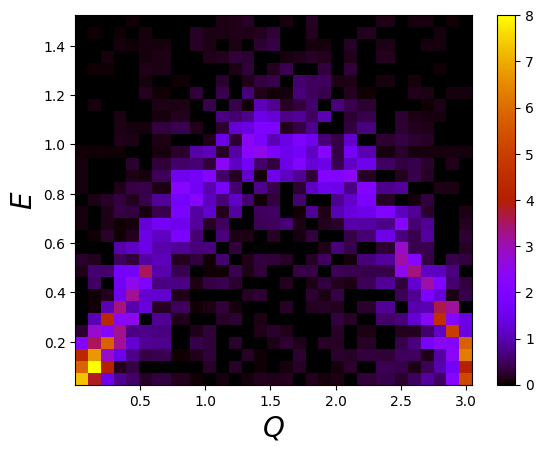

In [6]:
intensity.plot(blank=True)

### Create linear measurement system

Set instance for estimated spectrum.

In [7]:
spectrum = Spectrum()
spectrum.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

Set measurement matrix.

In [8]:
measurement_matrix = get_measurement_matrix(
    dQ, dE, grid_Q, grid_E, intensity, spectrum)

Set weight given by error in iexy file.

In [9]:
weight = get_weight(intensity)

## Spectrum estimation with $L_1$-TSV 

To estimate the true spectrum, we employ $L_1$-TSV optimization as
$$
\hat{\bm{S}} = \underset{\bm{S}}{\rm argmin}\ \chi^2(\bm{S}) + \lambda_l \|\bm{S}\|_1 + \lambda_{\rm TSV} \|\bm{S}\|_{\rm TSV} \quad\quad\quad {\text s.t.} \ \ S_j > 0 \ \ (j=1,\cdots,N).
$$.

The first term is the weighted-squared error given as

$$
\chi^2(\bm{S}) = \frac{1}{2}  \sum_{i=1}^M w_i \left(I_i - \sum_{j=1}^N R_{i,j} S_j \right)^2.
$$

The second term is the $L_1$ norm that introduces sparsity as

$$
\left\|\bm{S}\right\|_p = \left( \sum_k |S_k|^p \right)^{1/p}.
$$

The third term represents the total square variation regularization given as

$$
\left\| \bm{S} \right\|_{\rm TSV} = \frac{1}{2} \sum_{j} \sum_{j'\in \partial j} \left(S_j - S_{j'}\right)^2,
$$

where $\partial j$ represents the index set of pixels adjacent to the $j$-th pixel.

### Set TSV reguralization

In [10]:
tsvQ, tsvE = get_tsv_array(spectrum.size, spectrum.Qsize, spectrum.Esize)

### Hyper paramaeters $\lambda_2$ with empirical strategy

We need set the hyperparameters to performe $L_1$-TSV optimization. To avoid underestimating the TSV regularization, we employ an empirical strategy. In our strategy, $\lambda_{\rm TSV}$ is given as

$$
\lambda^{\rm Emp}_{\rm TSV} = \left\{ \max{\mathcal{R}} \right\}^{\eta},
$$

where $\mathcal{R}=\{ \sum_{i}w_{i}R_{i,j}R_{i,j'} | 1\le j,j' \le N\}$.

In [11]:
eta = 0.5
l2_emp = get_empirical_tsv_parameter(measurement_matrix, weight, eta=eta)

### Run ADMM solver

We run ADMM solver for exploring the estimated spectrum $\bm{S}^*$. 

In [12]:
admm = ADMMSolver()
spectrum.value = admm.fit(
    intensity.value,
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    l1=0.01, 
    l2=l2_emp)

Plot estimated result.

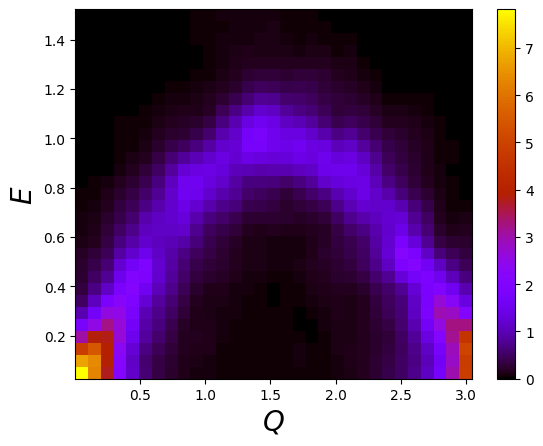

In [13]:
spectrum.plot(blank=False)

## Hyperparameter Tuning with Cross Validation (CV)

$L_1$+TSV has two hyperparameters, $\lambda_l$ and $\lambda_{\rm TSV}$, and therefore, we need to tune their values carefully. This software supports three different hyperparameter tuning methods. In this notebook, we perform hyperparameter tuning by setting $\lambda_l=10^{l_1}$ and $\lambda_{\rm TSV}=10^{l_2}$, where $l_1$ and $l_2$ range from $-4$ to $0$ with an increment of $0.25$.

In [14]:
l1_list = [10.0**i for i in np.arange(-4, 0.25, 0.25)] # \lambda_1
l2_list = [10.0**i for i in np.arange(-4, 0.25, 0.25)] # \lambda_TSV

### $K$-fold CV (KCV)

KCV is a well-known hyperparameter tuning method, which is widely used in practical applications. In KCV, the measured data is divided into $K$ subsets. These subsets are randomly selected from the original data, which indicates that each element appears exactly once across all subsets. For each fold, with using the $K-1$ subsets as the training set, we obtain the estimated spectrum and evalute KCV error.

In [15]:
cv = CrossValidationManager(
    intensity.value, 
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    solver=ADMMSolver(),
    num_folds=10,
    num_jobs=-1)

In [16]:
cv.run_grid_search(
    l1_list, 
    l2_list)

Show the estimated result obtained by KCV.

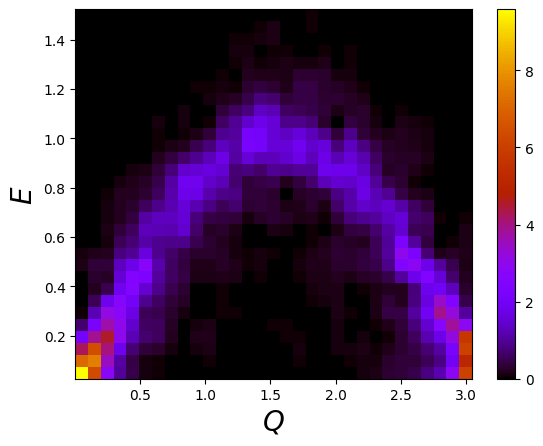

In [17]:
spectrum_cv = Spectrum()
spectrum_cv.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

spectrum_cv.value = cv.get_best_solution(selection_mode='Lowest Error')
spectrum_cv.plot()

### Emp+KCV

In Emp+KCV, we employ the empirical hyperparameter for TSV, $\lambda_{\rm TSV}^{\rm Emp}$. We perform KCV for tuning only the $\lambda_{1}$ value.

In [18]:
emp_cv = CrossValidationManager(
    intensity.value, 
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    solver=ADMMSolver(),
    num_folds=10,
    num_jobs=-1)

In [19]:
l2_emp = get_empirical_tsv_parameter(measurement_matrix, weight, eta=0.5)
l2_list = [l2_emp]

In [20]:
emp_cv.run_grid_search(
    l1_list, 
    l2_list)

Show the estimated result obtained by Emp+KCV.

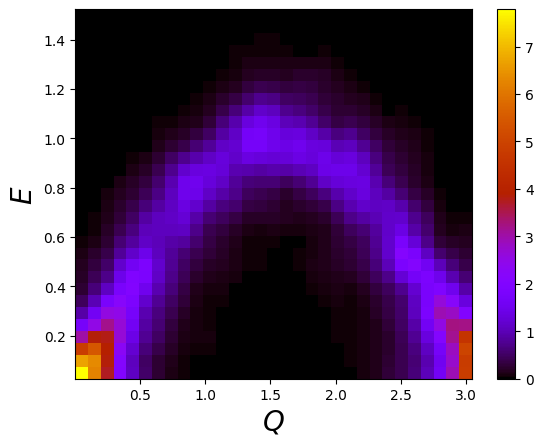

In [21]:
spectrum_emp_cv = Spectrum()
spectrum_emp_cv.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

spectrum_emp_cv.value = emp_cv.get_best_solution(selection_mode='Lowest Error')
spectrum_emp_cv.plot()

### Emp+LOOCV

In Emp+LOOCV, we employ the approximated LOOCV method proposed by Obuchi and Kabashima. This method significantly accelerate the computation speed in the hyperparameter tuning process.

In [22]:
emp_loocv = CrossValidationManager(
    intensity.value, 
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    solver=ADMMSolver())

In [23]:
emp_loocv.run_grid_search(
    l1_list, 
    l2_list,
    cv_type='LOOCV')

In [24]:
l2_emp = get_empirical_tsv_parameter(measurement_matrix, weight, eta=0.5)
l2_list = [l2_emp]

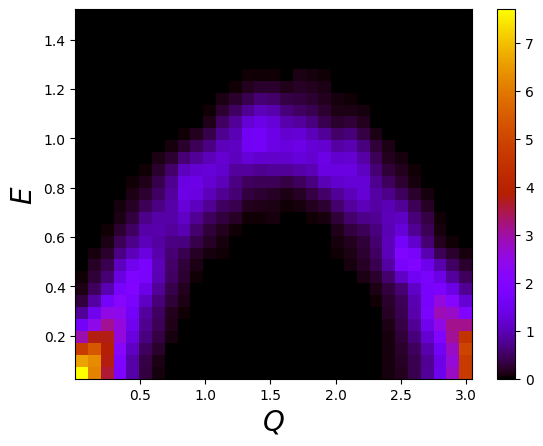

In [25]:
spectrum_emp_loocv = Spectrum()
spectrum_emp_loocv.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

spectrum_emp_loocv.value = emp_loocv.get_best_solution(selection_mode='Lowest Error')
spectrum_emp_loocv.plot()